In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt   
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm


In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick

# model path
val_rmse_str = "0.2541"   # same rmse in the filename

path_csv_load = save_path / f"{ticker}_final.csv"
path_csv_save = save_path / f"{ticker}_test_DF.csv"

model_path = save_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs_training/GOOGL_0.2541.pth')

In [3]:
df = pd.read_csv(path_csv_load, index_col=0, parse_dates=True)
df

open        high         low       close       r_1  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845 -0.000180   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690 -0.000180   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534 -0.000180   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379 -0.000180   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224 -0.000180   
...                         ...         ...         ...         ...       ...   
2025-06-18 20:56:00  173.375000  173.677100  173.215000  173.565000  0.001124   
2025-06-18 20:57:00  173.565000  173.590000  173.240000  173.380000 -0.001066   
2025-06-18 20:58:00  173.390000  173.410000  173.200000  173.310000 -0.000404   
2025-06-18 20:59:00  173.315000  173.400000  173.230000  173.280000 -0.000173   
2025-06-18 21:00:00  173.300000  174.050000  173.170000  173.609700  0.001901   

                          r_5  volume_spike    atr_14     rsi_14        ma_5  \
2014-04-03 12:06:00 -0.000180      0.568641  0.000368   0.000000   28.648969   
2014-04-03 12:07:00 -0.000360      0.570338  0.000736   0.000000   28.646907   
2014-04-03 12:08:00 -0.000540      0.574408  0.001105   0.000000   28.643814   
2014-04-03 12:09:00 -0.000720      0.581017  0.001473   0.000000   28.639690   
2014-04-03 12:10:00 -0.000900      0.590413  0.001841   0.000000   28.634534   
...                       ...           ...       ...        ...         ...   
2025-06-18 20:56:00 -0.004226      2.462713  0.304529  17.019768  173.913000   
2025-06-18 20:57:00 -0.005063      2.154838  0.317029  11.648165  173.737000   
2025-06-18 20:58:00 -0.005811      1.439161  0.323814  11.384870  173.535000   
2025-06-18 20:59:00 -0.004434      2.836382  0.322743  11.830567  173.381000   
2025-06-18 21:00:00  0.001382      8.568493  0.374521  22.962317  173.428940   

                     macd_12_26         bid         ask  signal_smooth  
2014-04-03 12:06:00   -0.000411   28.636251   28.653438       0.348124  
2014-04-03 12:07:00   -0.001140   28.631098   28.648282       0.350528  
2014-04-03 12:08:00   -0.002109   28.625944   28.643125       0.352926  
2014-04-03 12:09:00   -0.003256   28.620791   28.637968       0.355320  
2014-04-03 12:10:00   -0.004528   28.615637   28.632811       0.357710  
...                         ...         ...         ...            ...  
2025-06-18 20:56:00   -0.422065  173.512900  173.617100       0.002995  
2025-06-18 20:57:00   -0.466939  173.328000  173.432000       0.002906  
2025-06-18 20:58:00   -0.502359  173.258000  173.362000       0.005611  
2025-06-18 20:59:00   -0.526778  173.228000  173.332000       0.006685  
2025-06-18 21:00:00   -0.513606  173.557600  173.661800       0.003506  

[1856408 rows x 14 columns]

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

model_best


{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 4,
 'CLIPNORM': 0.9,
 'DROPOUT_LONG': 0.3,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 12,
 'ETA_MIN': 1e-05,
 'INITIAL_LR': 0.001,
 'LONG_UNITS': 64,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 48,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


DualMemoryLSTM(
  (short_lstm): LSTM(11, 48, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(48, 64, batch_first=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:

print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=881299, val=228190, te=239319
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.51603
Test zero‐forecast baseline RMSE = 0.55215


std val: 0.32934162
std test: 0.3403753


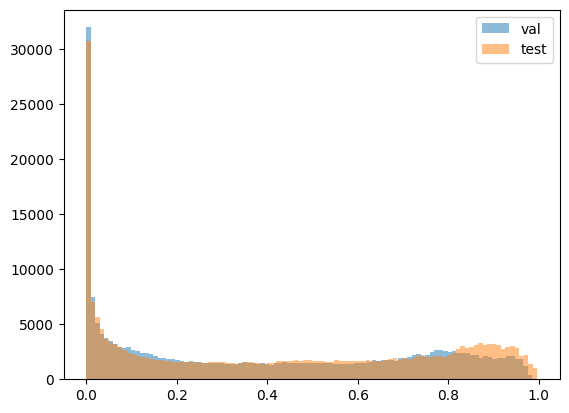

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test"
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats
            total_sq_error += (pred - y).pow(2).sum().item()
            total_windows  += y.numel()

            all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    rmse = math.sqrt(total_sq_error / total_windows)
    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [9]:
val_rmse, val_preds     = evaluate_model(model_best, val_loader, device, split_name="Validation")
test_rmse, test_preds   = evaluate_model(model_best, test_loader, device, split_name="Test")

test_preds.shape

Validation:   0%|          | 0/414 [00:00<?, ?day/s]


Validation RMSE over 228190 windows = 0.25366


Test:   0%|          | 0/422 [00:00<?, ?day/s]


Test RMSE over 239319 windows = 0.29155


(239319,)

In [10]:

def add_pred_actions(
    df: pd.DataFrame,
    preds: np.ndarray,
    look_back: int,
    day_id_te: np.ndarray,
    pred_threshold: float,
    trailing_stop_thresh: float,
    regular_start_shifted: datetime.time,
    path_csv_save: str
) -> pd.DataFrame:
    """
    Returns a full-day DataFrame augmented with
      - pred_signal (NaN outside test-window)
      - pred_action (integer: -1/0/+1 everywhere)
    so downstream sim & plotting see the full x-axis.
    """
    # 1) Copy & init columns
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0  # default: no trade

    # 2) Identify test‐days by index normalize & map via day_id_te
    all_days = sorted(df_out.index.normalize().unique())
    test_ids = np.unique(day_id_te).astype(int)
    test_days = [all_days[i] for i in test_ids]

    # 3) Build mask of all post-start rows on test days
    mask = (
        df_out.index.normalize().isin(test_days)
        & (df_out.index.time >= regular_start_shifted) 
    )
    cand = df_out.loc[mask]

    # 4) Within each test day, drop the initial look_back rows
    valid_idx = (
        cand
        .groupby(cand.index.normalize(), sort=False)
        .apply(lambda g: g.index[look_back:])
        .explode()
    )
    valid_idx = pd.DatetimeIndex(valid_idx.values)

    # 5) Stamp your model’s predictions on those valid slots
    if len(valid_idx) != len(preds):
        raise ValueError(
            f"Expected {len(valid_idx)} prediction slots, got {len(preds)} preds"
        )
    df_out.loc[valid_idx, "pred_signal"] = preds

    # 6) Generate & write back integer actions per test day
    for day in test_days:
        # slice just that day
        day_slice = df_out[df_out.index.normalize() == day]

        # generate_trade_actions expects pred_signal + writes pred_action
        day_actions = trades.generate_trade_actions(
            df                   = day_slice,
            col_signal           = "pred_signal",
            col_action           = "pred_action",
            buy_threshold        = pred_threshold,
            trailing_stop_thresh = trailing_stop_thresh,
            regular_start        = params.regular_start
        )

        # overwrite int actions only on real trade timestamps
        df_out.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"]
            .fillna(0)
            .astype(int)
        )

    # 7) (Optional) persist for inspection
    df_out.to_csv(path_csv_save)

    return df_out


In [11]:
df_with_preds = add_pred_actions(
    df, test_preds, look_back,
    day_id_te, pred_threshold,
    trailing_stop_thresh, regular_start_shifted,
    path_csv_save
)

df_with_preds

open        high         low       close       r_1  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845 -0.000180   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690 -0.000180   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534 -0.000180   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379 -0.000180   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224 -0.000180   
...                         ...         ...         ...         ...       ...   
2025-06-18 20:56:00  173.375000  173.677100  173.215000  173.565000  0.001124   
2025-06-18 20:57:00  173.565000  173.590000  173.240000  173.380000 -0.001066   
2025-06-18 20:58:00  173.390000  173.410000  173.200000  173.310000 -0.000404   
2025-06-18 20:59:00  173.315000  173.400000  173.230000  173.280000 -0.000173   
2025-06-18 21:00:00  173.300000  174.050000  173.170000  173.609700  0.001901   

                          r_5  volume_spike    atr_14     rsi_14        ma_5  \
2014-04-03 12:06:00 -0.000180      0.568641  0.000368   0.000000   28.648969   
2014-04-03 12:07:00 -0.000360      0.570338  0.000736   0.000000   28.646907   
2014-04-03 12:08:00 -0.000540      0.574408  0.001105   0.000000   28.643814   
2014-04-03 12:09:00 -0.000720      0.581017  0.001473   0.000000   28.639690   
2014-04-03 12:10:00 -0.000900      0.590413  0.001841   0.000000   28.634534   
...                       ...           ...       ...        ...         ...   
2025-06-18 20:56:00 -0.004226      2.462713  0.304529  17.019768  173.913000   
2025-06-18 20:57:00 -0.005063      2.154838  0.317029  11.648165  173.737000   
2025-06-18 20:58:00 -0.005811      1.439161  0.323814  11.384870  173.535000   
2025-06-18 20:59:00 -0.004434      2.836382  0.322743  11.830567  173.381000   
2025-06-18 21:00:00  0.001382      8.568493  0.374521  22.962317  173.428940   

                     macd_12_26         bid         ask  signal_smooth  \
2014-04-03 12:06:00   -0.000411   28.636251   28.653438       0.348124   
2014-04-03 12:07:00   -0.001140   28.631098   28.648282       0.350528   
2014-04-03 12:08:00   -0.002109   28.625944   28.643125       0.352926   
2014-04-03 12:09:00   -0.003256   28.620791   28.637968       0.355320   
2014-04-03 12:10:00   -0.004528   28.615637   28.632811       0.357710   
...                         ...         ...         ...            ...   
2025-06-18 20:56:00   -0.422065  173.512900  173.617100       0.002995   
2025-06-18 20:57:00   -0.466939  173.328000  173.432000       0.002906   
2025-06-18 20:58:00   -0.502359  173.258000  173.362000       0.005611   
2025-06-18 20:59:00   -0.526778  173.228000  173.332000       0.006685   
2025-06-18 21:00:00   -0.513606  173.557600  173.661800       0.003506   

                     pred_signal  pred_action  
2014-04-03 12:06:00          NaN            0  
2014-04-03 12:07:00          NaN            0  
2014-04-03 12:08:00          NaN            0  
2014-04-03 12:09:00          NaN            0  
2014-04-03 12:10:00          NaN            0  
...                          ...          ...  
2025-06-18 20:56:00     0.324952            0  
2025-06-18 20:57:00     0.328711            0  
2025-06-18 20:58:00     0.330725            0  
2025-06-18 20:59:00     0.336076            0  
2025-06-18 21:00:00     0.337900           -1  

[1856408 rows x 16 columns]

In [12]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,              # full DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2024-06:


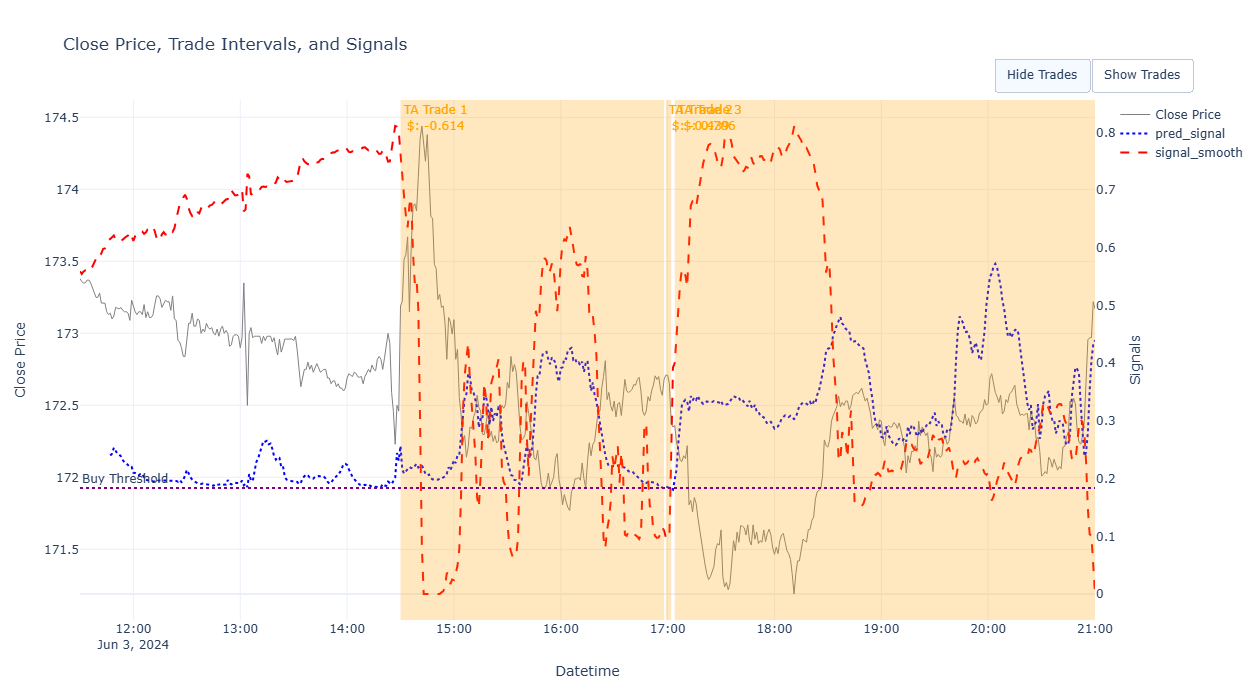


=== Performance for 2024-06-03 00:00:00 ===
Strategy Return ($): -0.296
Buy & Hold Return ($): -0.074
Trades Returns ($): [-0.614, -0.439, 0.706]


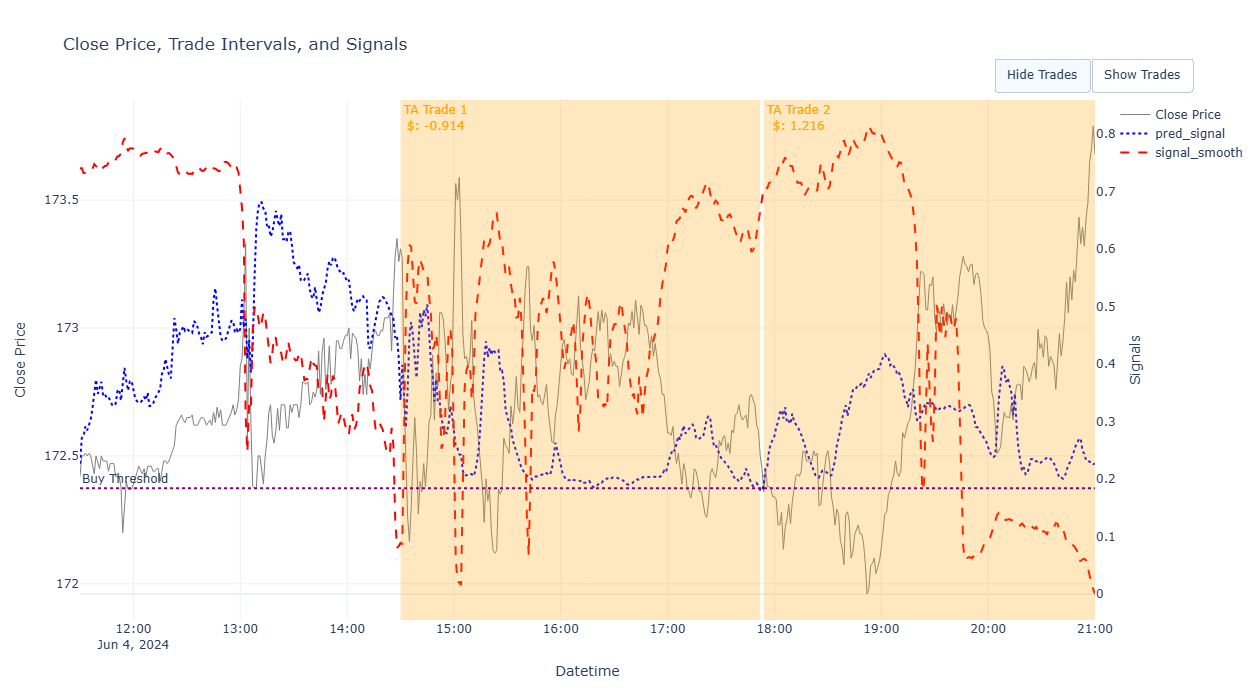


=== Performance for 2024-06-04 00:00:00 ===
Strategy Return ($): 0.412
Buy & Hold Return ($): 0.376
Trades Returns ($): [-0.914, 1.216]


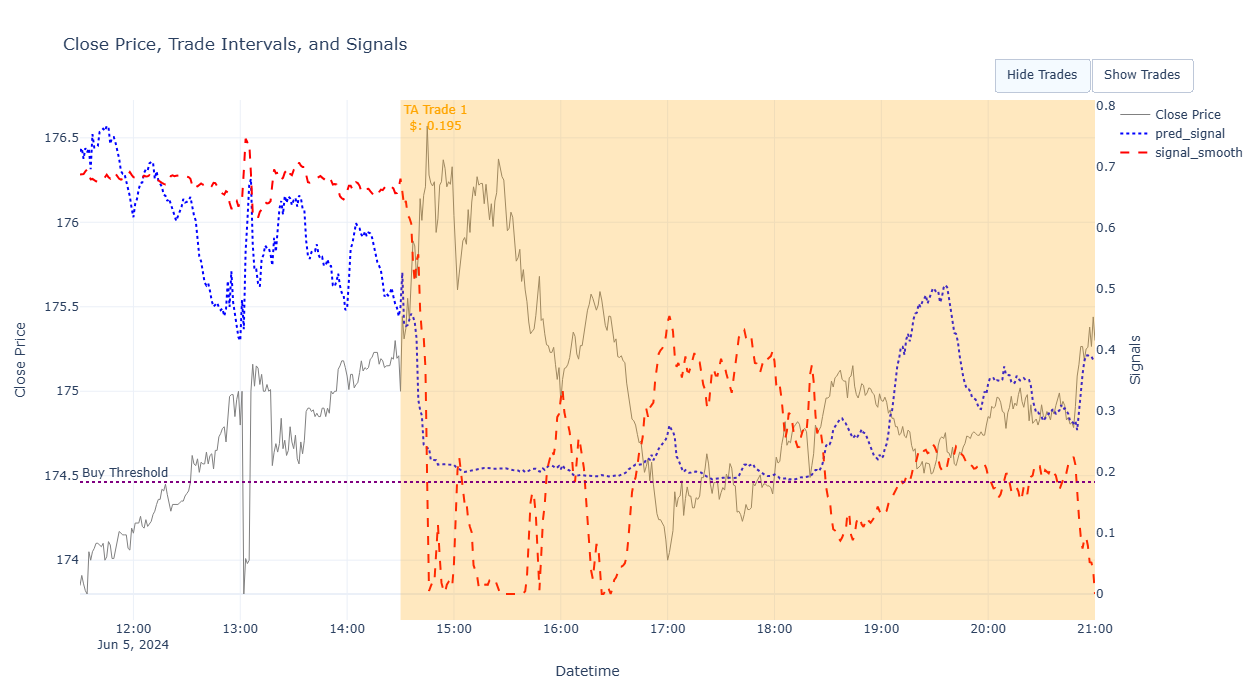


=== Performance for 2024-06-05 00:00:00 ===
Strategy Return ($): 0.335
Buy & Hold Return ($): 0.335
Trades Returns ($): [0.195]


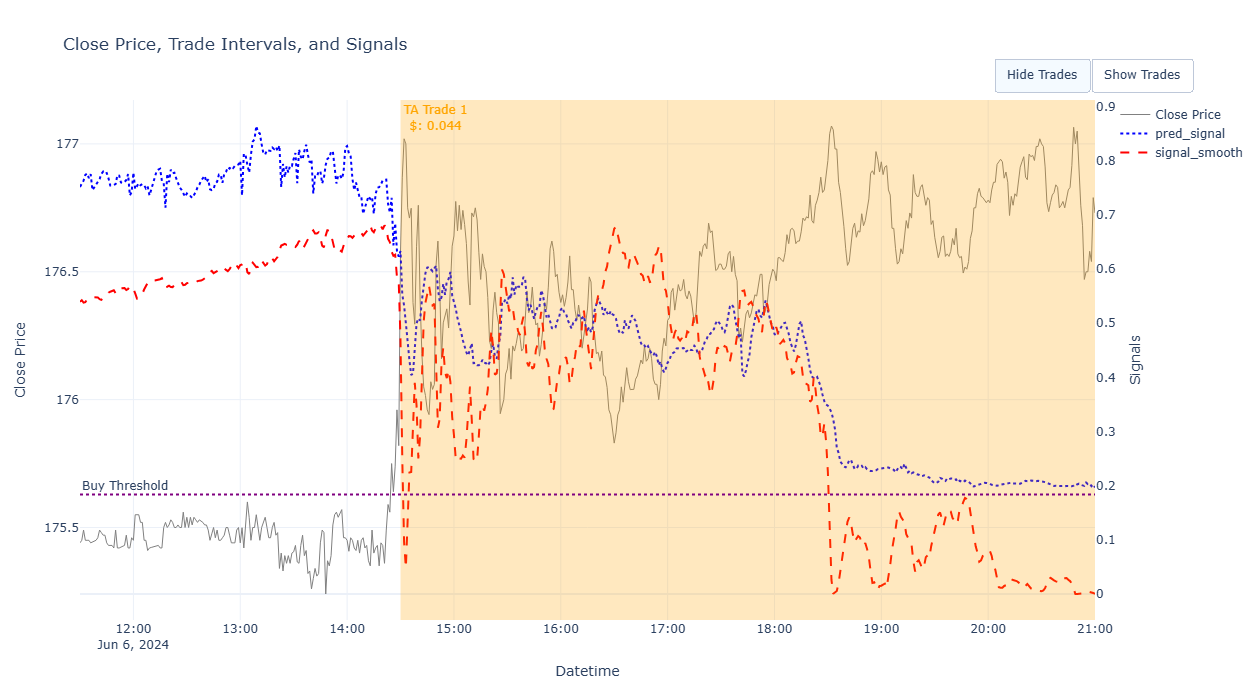


=== Performance for 2024-06-06 00:00:00 ===
Strategy Return ($): 0.104
Buy & Hold Return ($): 0.104
Trades Returns ($): [0.044]


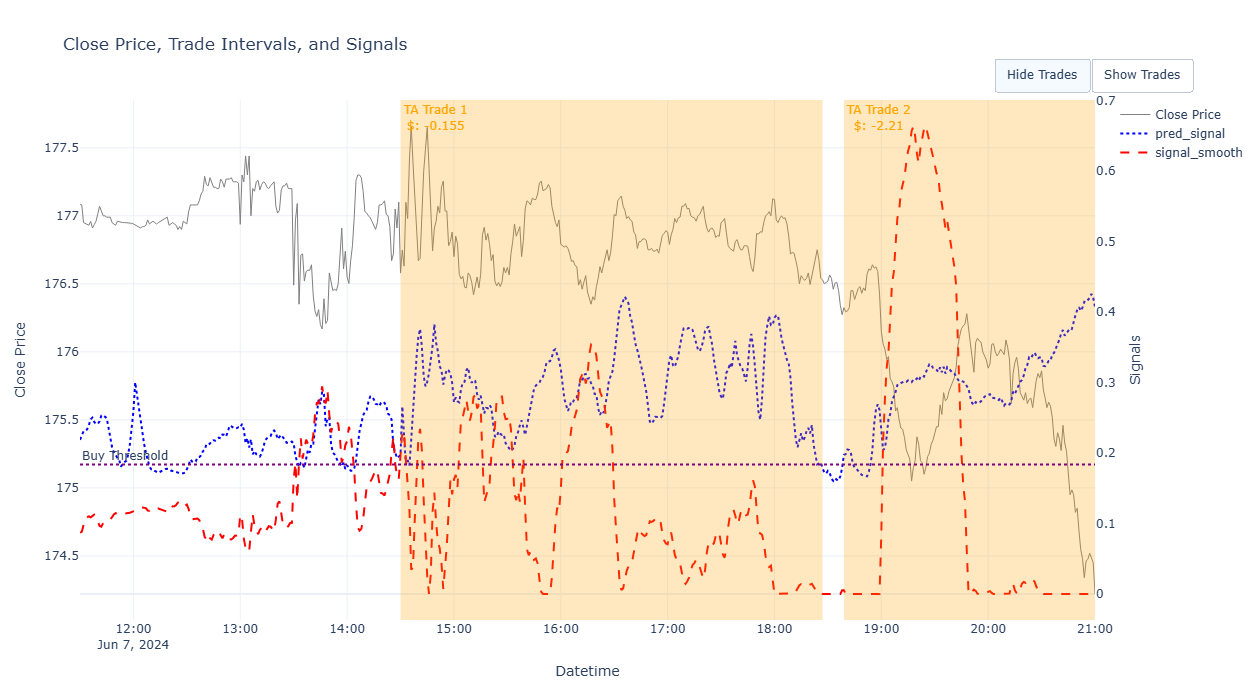


=== Performance for 2024-06-07 00:00:00 ===
Strategy Return ($): -2.135
Buy & Hold Return ($): -2.234
Trades Returns ($): [-0.155, -2.21]


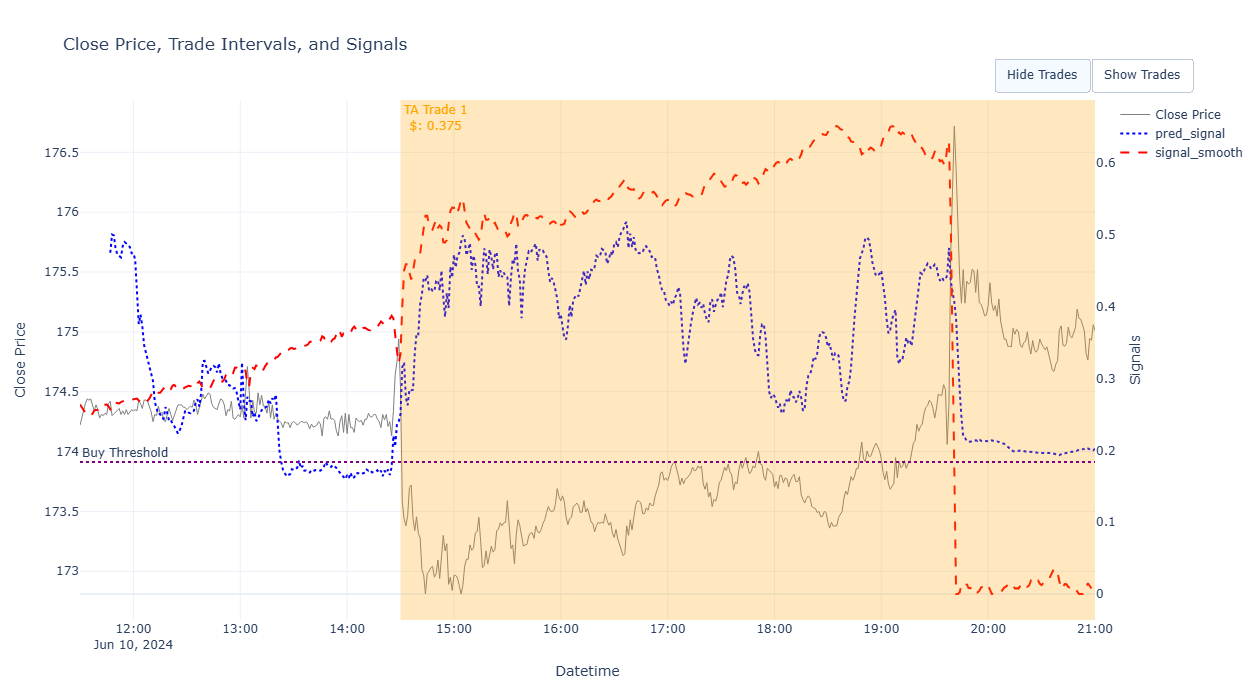


=== Performance for 2024-06-10 00:00:00 ===
Strategy Return ($): 0.425
Buy & Hold Return ($): 0.425
Trades Returns ($): [0.375]


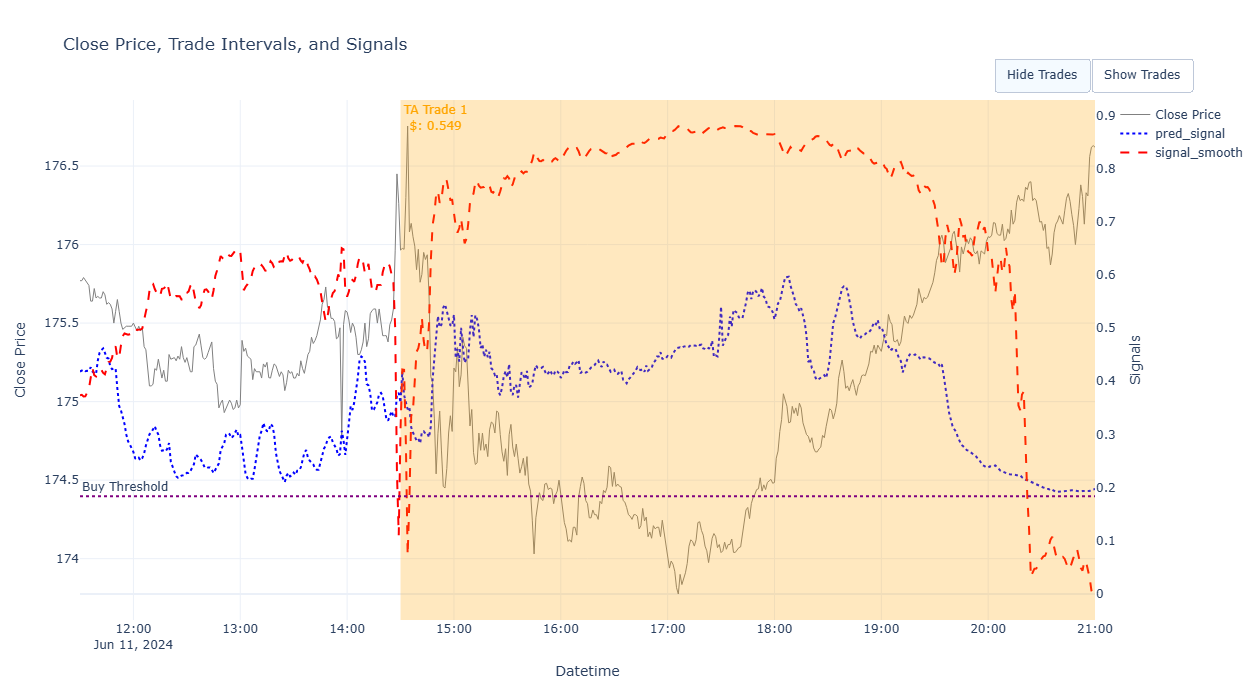


=== Performance for 2024-06-11 00:00:00 ===
Strategy Return ($): 0.559
Buy & Hold Return ($): 0.559
Trades Returns ($): [0.549]


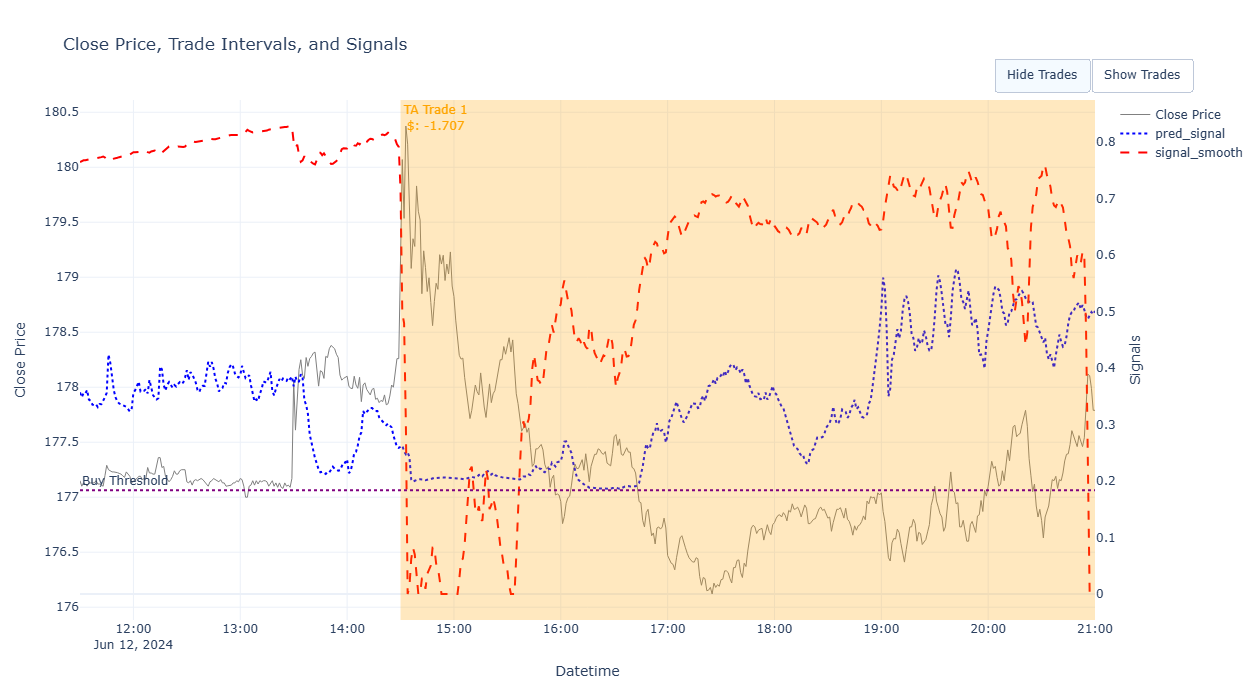


=== Performance for 2024-06-12 00:00:00 ===
Strategy Return ($): -1.707
Buy & Hold Return ($): -1.707
Trades Returns ($): [-1.707]


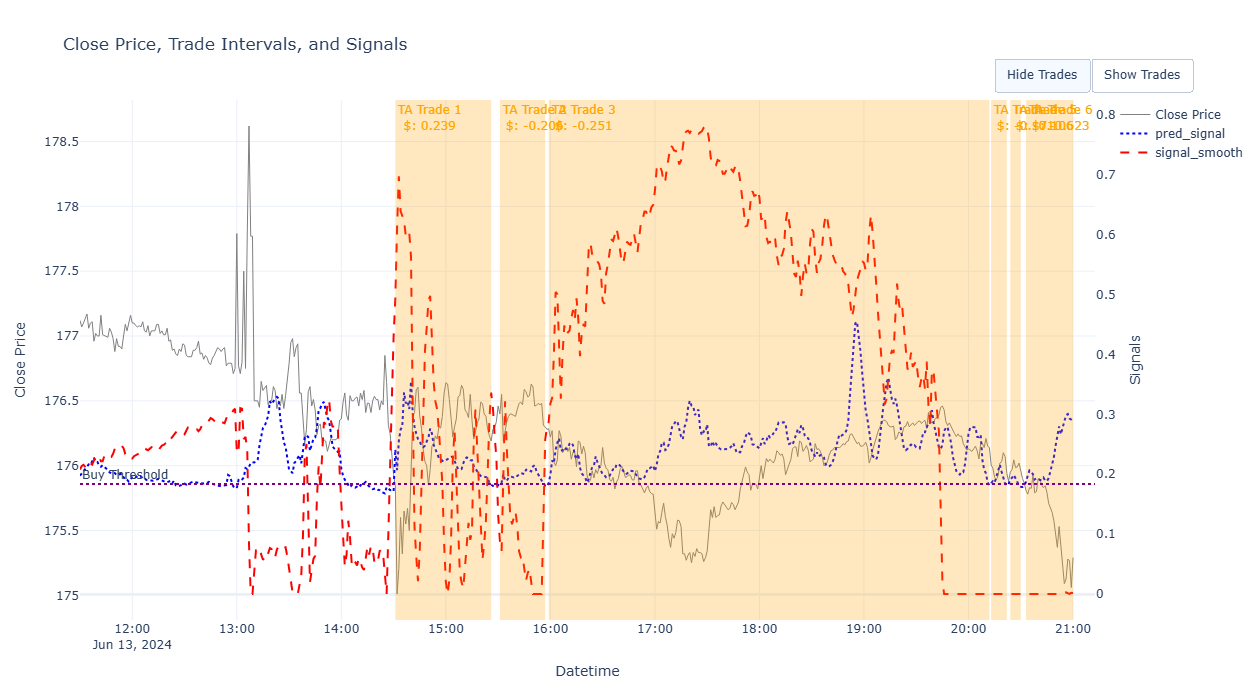


=== Performance for 2024-06-13 00:00:00 ===
Strategy Return ($): -1.346
Buy & Hold Return ($): -0.975
Trades Returns ($): [0.239, -0.206, -0.251, -0.171, -0.106, -0.623]


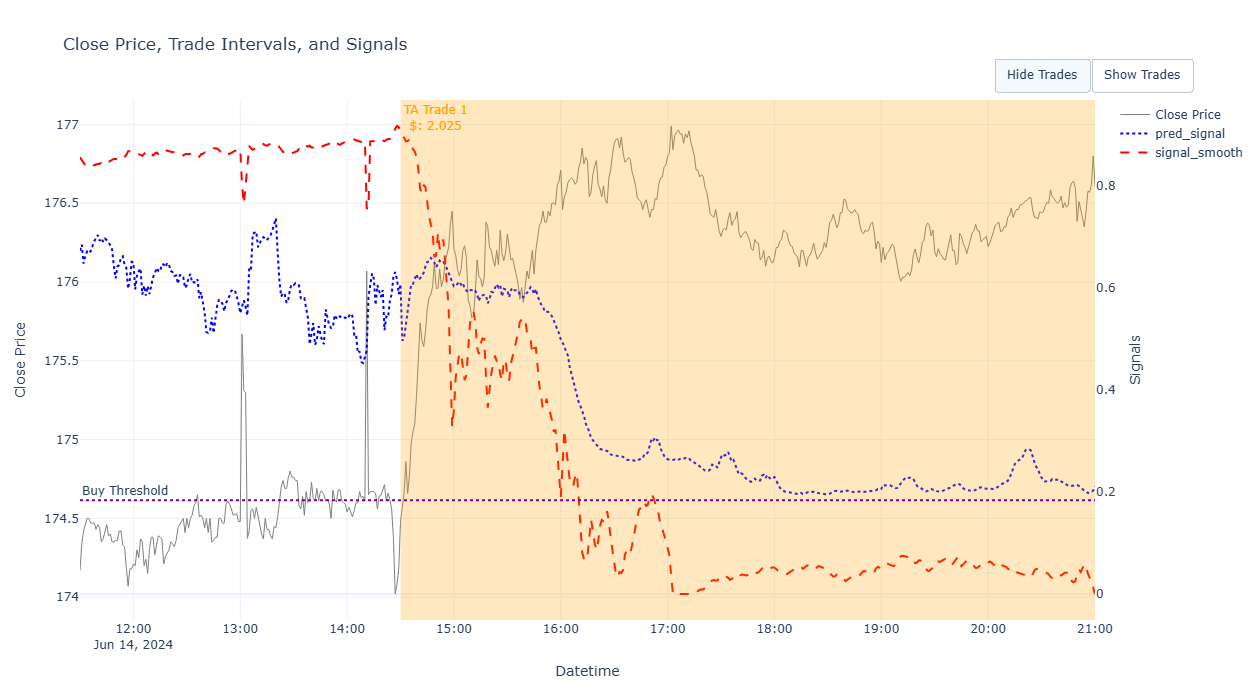


=== Performance for 2024-06-14 00:00:00 ===
Strategy Return ($): 2.215
Buy & Hold Return ($): 2.215
Trades Returns ($): [2.025]


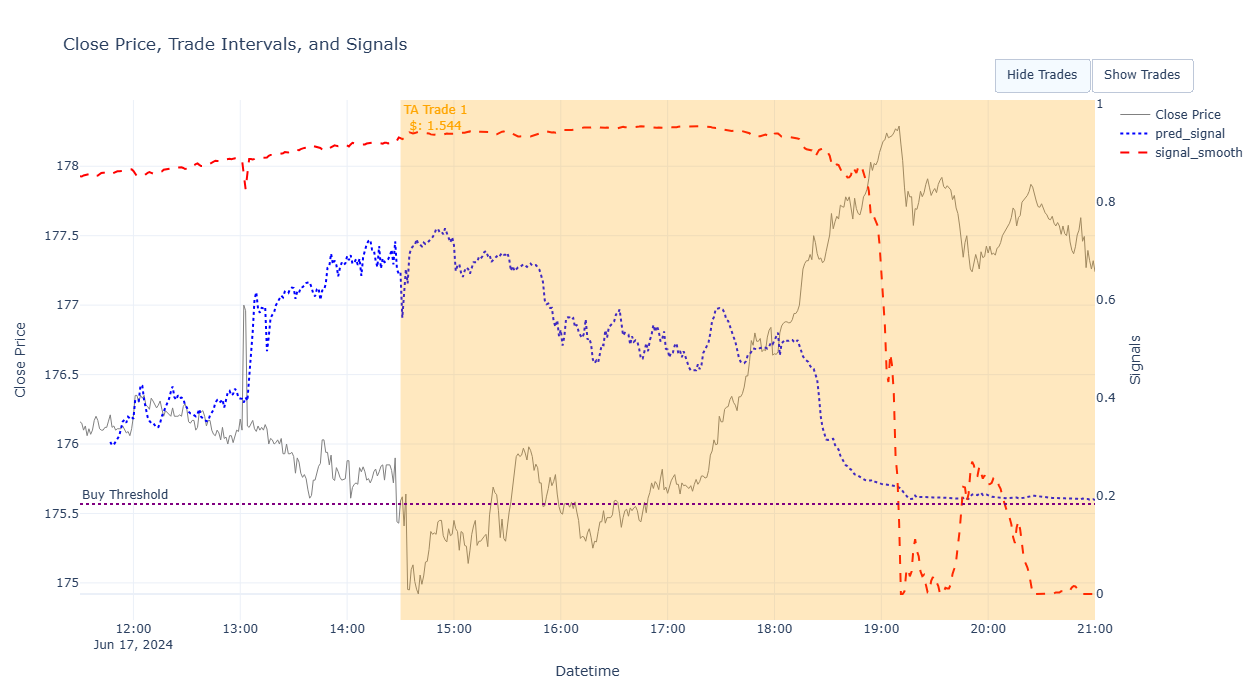


=== Performance for 2024-06-17 00:00:00 ===
Strategy Return ($): 1.624
Buy & Hold Return ($): 1.624
Trades Returns ($): [1.544]


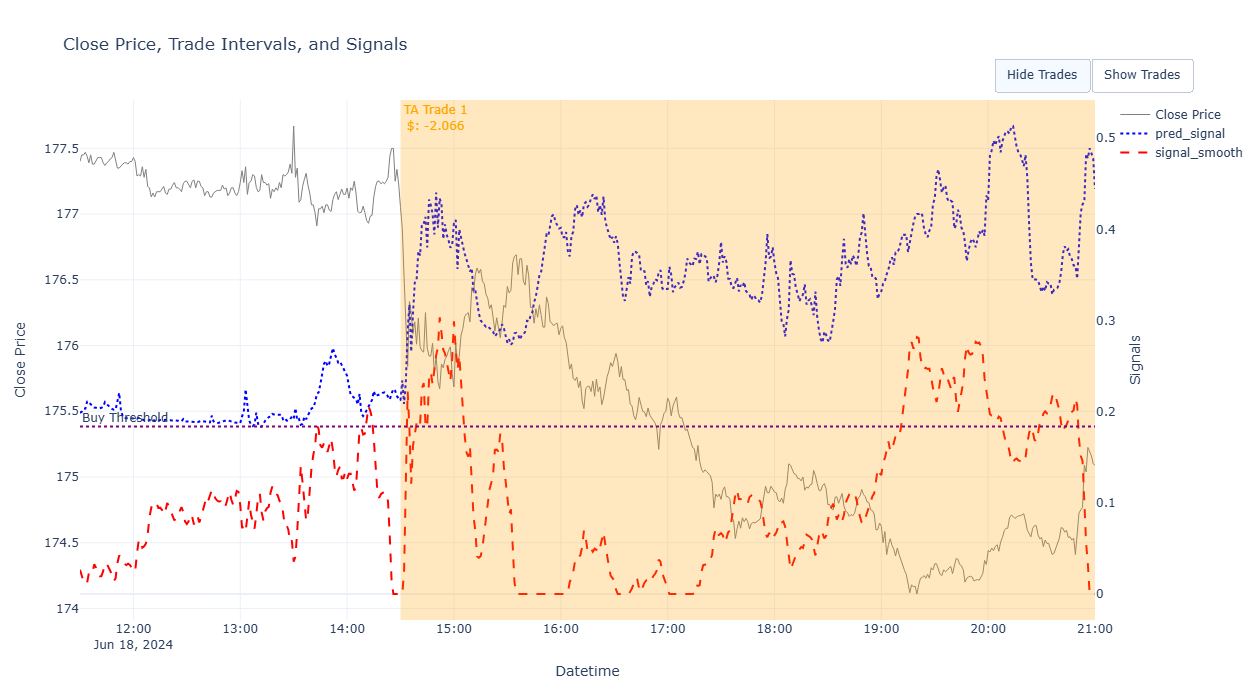


=== Performance for 2024-06-18 00:00:00 ===
Strategy Return ($): -2.056
Buy & Hold Return ($): -2.056
Trades Returns ($): [-2.066]


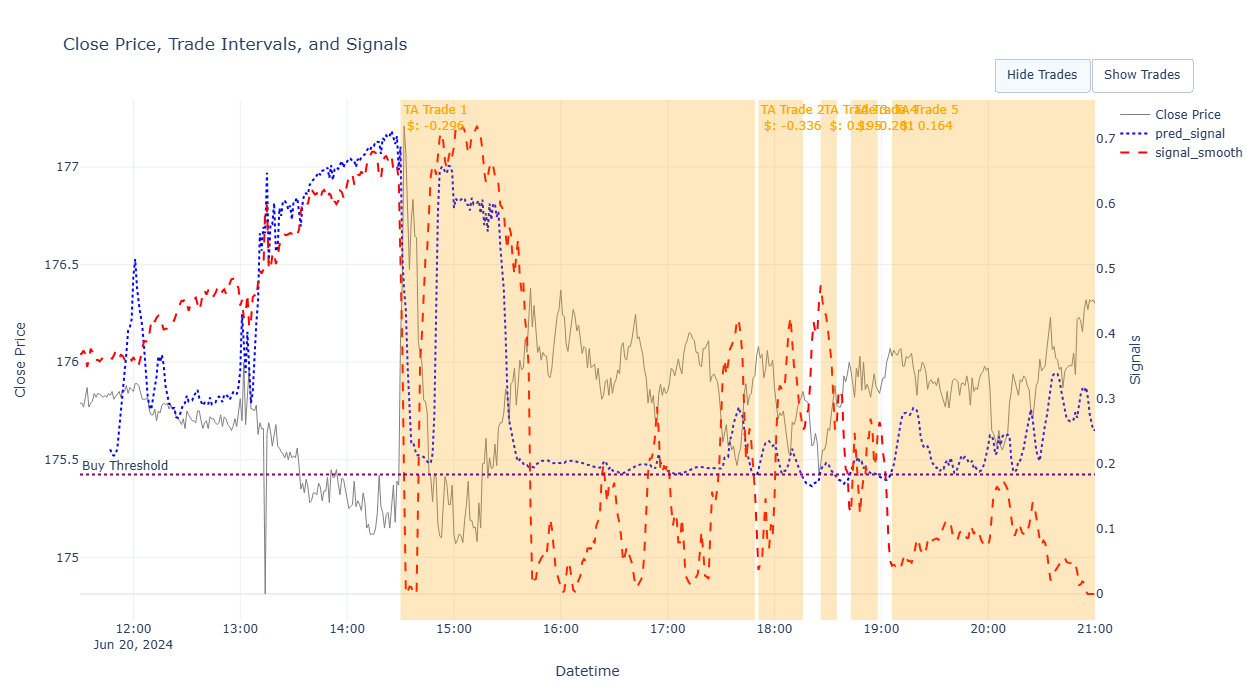


=== Performance for 2024-06-20 00:00:00 ===
Strategy Return ($): -0.453
Buy & Hold Return ($): 0.094
Trades Returns ($): [-0.296, -0.336, 0.195, -0.201, 0.164]


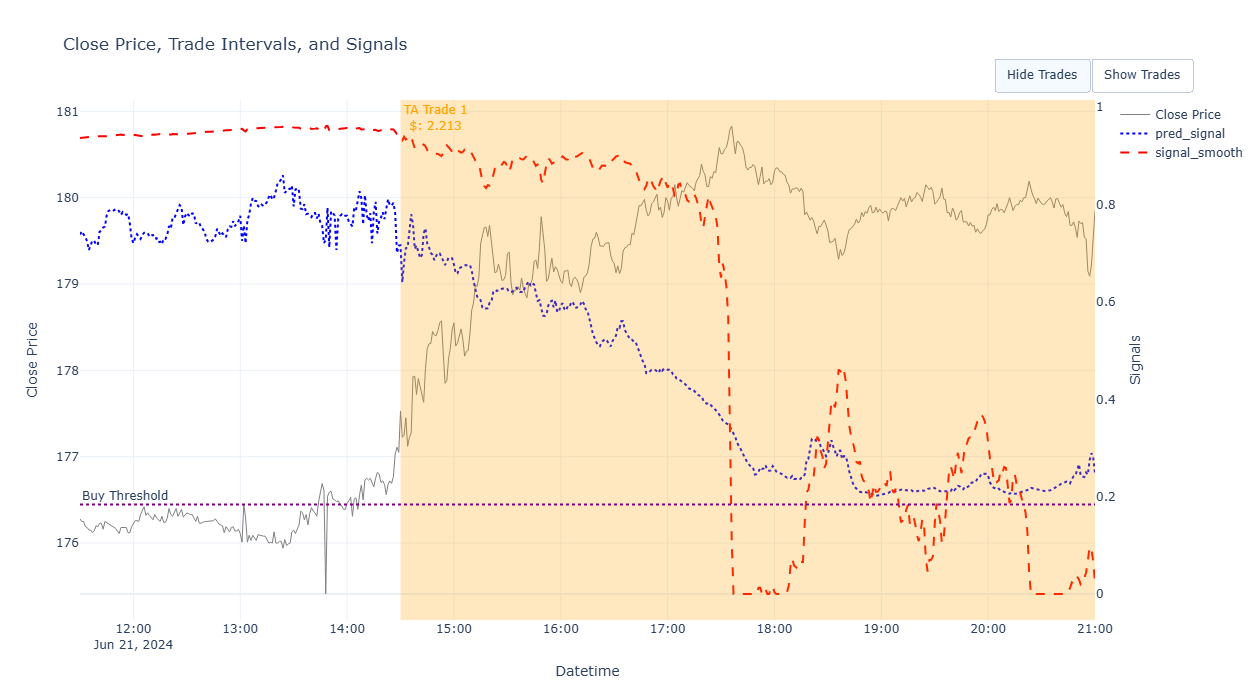


=== Performance for 2024-06-21 00:00:00 ===
Strategy Return ($): 1.873
Buy & Hold Return ($): 1.873
Trades Returns ($): [2.213]


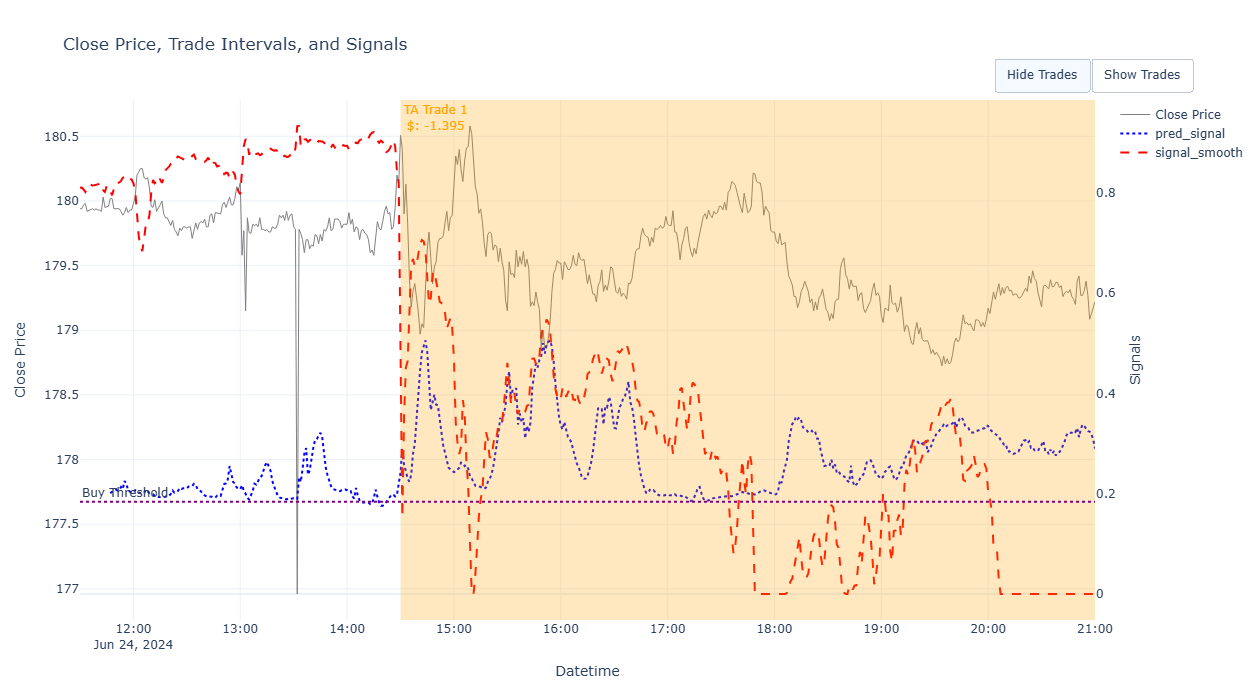


=== Performance for 2024-06-24 00:00:00 ===
Strategy Return ($): -1.455
Buy & Hold Return ($): -1.455
Trades Returns ($): [-1.395]


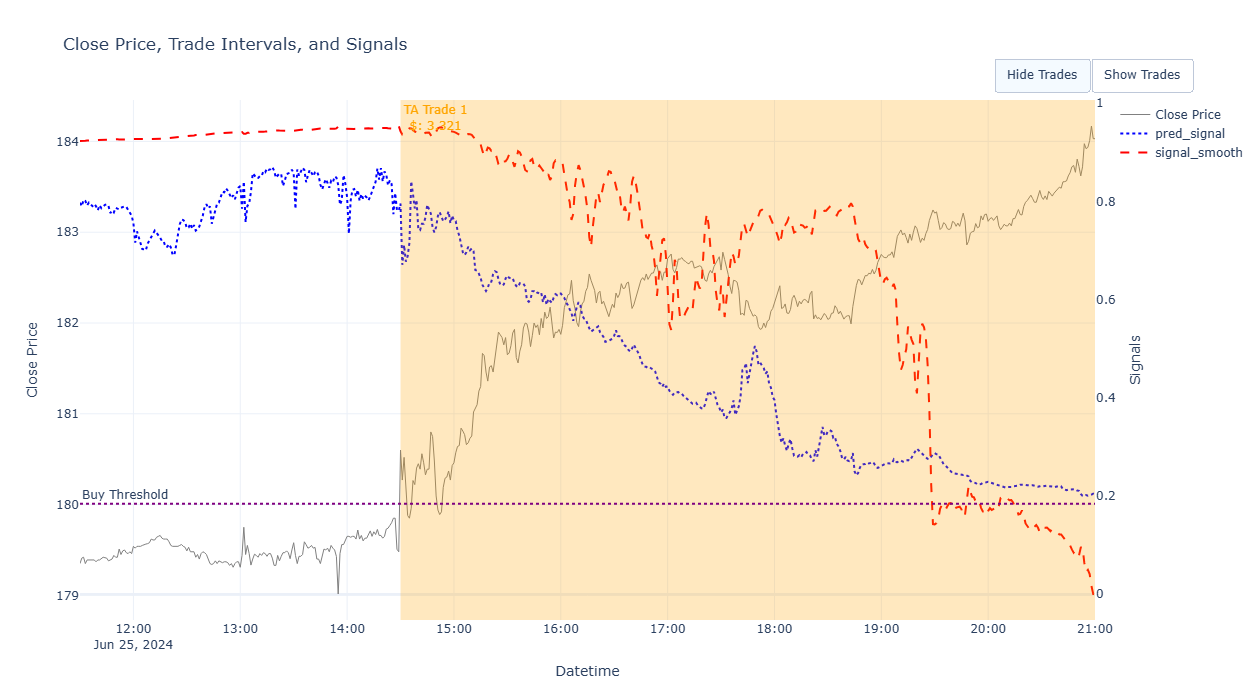


=== Performance for 2024-06-25 00:00:00 ===
Strategy Return ($): 3.321
Buy & Hold Return ($): 3.321
Trades Returns ($): [3.321]


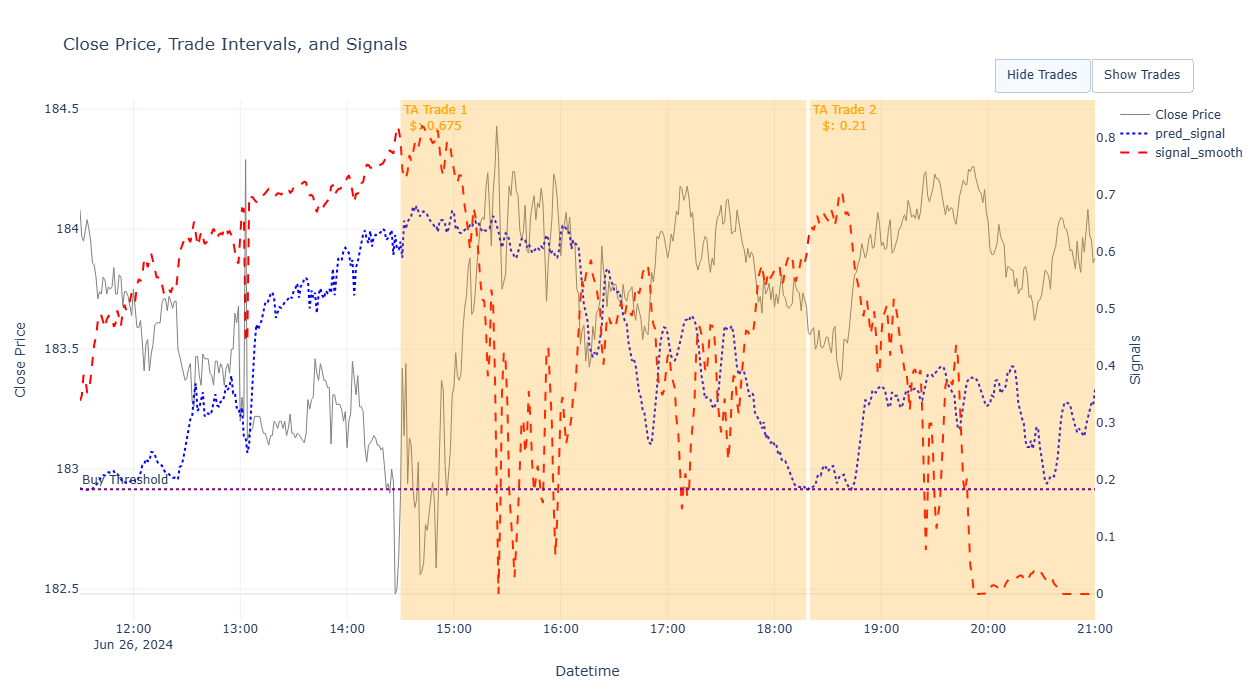


=== Performance for 2024-06-26 00:00:00 ===
Strategy Return ($): 0.865
Buy & Hold Return ($): 0.86
Trades Returns ($): [0.675, 0.21]


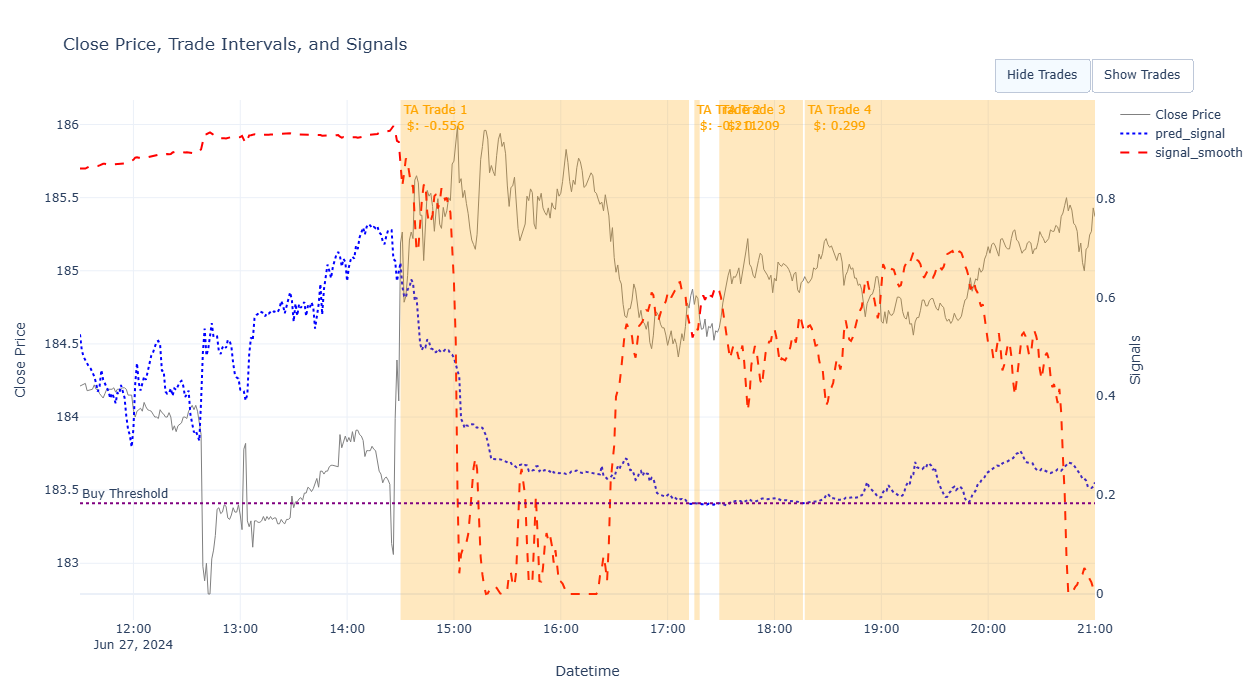


=== Performance for 2024-06-27 00:00:00 ===
Strategy Return ($): -0.199
Buy & Hold Return ($): 0.129
Trades Returns ($): [-0.556, -0.211, 0.209, 0.299]


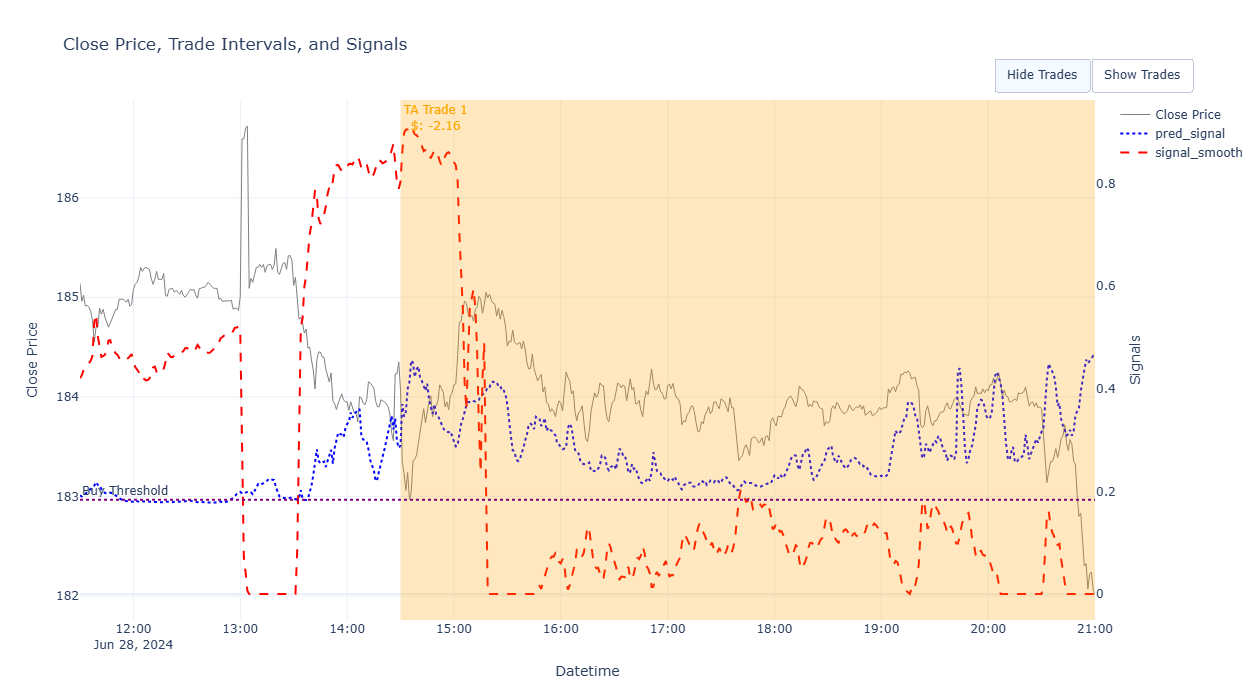


=== Performance for 2024-06-28 00:00:00 ===
Strategy Return ($): -2.12
Buy & Hold Return ($): -2.12
Trades Returns ($): [-2.16]

=== Overall Summary (2024-06-03 → 2024-06-28) ===
Start date price: 2024-06-03 = 173.2420
  End date price:  2024-06-28 = 181.9654
One-time buy&hold gain: 8.723

{'Buy & Hold – each day ($)': 1.294,
 'Strategy Return ($)': -0.034,
 'Trades Returns ($)': '36 trades'}

=== Overall Summary (2014-04-03 → 2025-06-18) ===
Start date price: 2014-04-03 = 28.5931
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 144.965

{'Buy & Hold – each day ($)': -126.583,
 'Strategy Return ($)': -94.084,
 'Trades Returns ($)': '800 trades'}


In [13]:
importlib.reload(params)

# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
